# 2. Audio Classification

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import librosa
import random
import wave
import os

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import TruncatedSVD

from sklearn.preprocessing import normalize
from scipy.io import wavfile

In [15]:
def trimAudio(samples, percent_of_max_val = .2):
    plot_signal = []
    
    max_val = max(samples)

    started = False
    ended = False

    for x, val in enumerate(samples):

        if val > .1 * max_val:
            ended = False
            if not started:
                started = True
                start_x = x
        else:
            if not ended:
                ended = True
                end_x = x

        plot_signal.append(abs(val))
        
    return plot_signal[start_x:end_x]

def getCleanFourierSamples(time_samples, min_frequency, max_frequency):
    fourier_samples = np.fft.fft(time_samples)
    
    # Just take half of the frequencies (specularity)
    fourier_samples = fourier_samples[int(len(fourier_samples)/2):]
    
    # Just take the first max_frequency samples
    fourier_samples_len = len(fourier_samples)
    if fourier_samples_len > max_frequency:
        fourier_samples = fourier_samples[:MAX_FREQUENCY]
    elif fourier_samples_len < max_frequency:
        padding_elements_number = max_frequency - fourier_samples_len
        fourier_samples = np.concatenate((fourier_samples, np.zeros(padding_elements_number)), axis=None)
        
    # Just take samples from min_frequency
    fourier_samples = fourier_samples[min_frequency:]
    
    # Return the abs
    fourier_samples = np.absolute(fourier_samples)
    
    return fourier_samples

def getCleanTimeSamples(time_samples):
    time_samples = np.array(trimAudio(time_samples))
    
    return time_samples

In [18]:
def arrayCuttingOrPadding(array, fixed_length, fill_with=0):
    """Converts any array to an array of a fixed length.
    If the original length is greater than the desired one, the array will be truncated.
    If the original length is lower than the desired one, the array will be filled with desired value at the end."""
    
    array_len = len(array)
    if array_len > fixed_length:
        array = array[:fixed_length]
    elif array_len < fixed_length:
        padding_elements_number = fixed_length - array_len
        array = np.pad(array=array, pad_width=(0, padding_elements_number), mode='constant', constant_values=fill_with)
    
    return array

def getFeaturesFromSamples(signal, rate):
    FIXED_SIGNAL_NUMBER_OF_SAMPLES = 5000
    
    signal = arrayCuttingOrPadding(signal, FIXED_SIGNAL_NUMBER_OF_SAMPLES)

    # Compute MFCC features from the raw signal after having normalized
    signal = librosa.util.normalize(signal, norm=2)
    mfcc = librosa.feature.mfcc(y=signal, sr=rate, n_mfcc=26, dct_type=2)
    
    # Convert the matrix in an 1-D array of features by taking the rows one after the other and concatening them
    curr_features = np.empty(0)
    for i in range(mfcc.shape[0]):
        curr_features = np.concatenate((curr_features, mfcc[i]))
    
    return curr_features

## 2.1 Load training set

In [19]:
PATH_TO_FILES = './datasets/dev/'
files = os.listdir(PATH_TO_FILES)

X = []
y = []

for file in files:
    # Get the label from file name
    audio_label = int(file.split("_")[1].split('.')[0])
    
    # Load the signal using lobrosa
    signal, rate = librosa.load(PATH_TO_FILES + file, sr=None)
    
    # Compute the features array
    features = getFeaturesFromSamples(signal, rate)
    
    # Append the array as row to the features matrix
    X.append(features)
    
    # Link the features to the current label for training
    y.append(audio_label)

## 2.2 Train classifier

MEAN: 0.9733907465122937


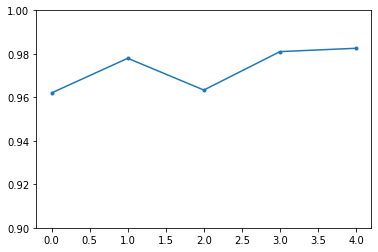

In [20]:
from sklearn.metrics import precision_recall_fscore_support

from sklearn.model_selection import KFold
# from sklearn.naive_bayes import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn import svm

kf = KFold(n_splits=5, random_state=22)

# loo = LeaveOneOut()
# loo.get_n_splits(X)

f1_values = []
for train_indices, test_indices in kf.split(X, y):
    X_train, X_test = [X[i] for i in train_indices], [X[i] for i in test_indices] 
    y_train, y_test = [y[i] for i in train_indices], [y[i] for i in test_indices]
    
    # Train and evaluate
    clf = RandomForestClassifier(n_estimators = 100)
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    
    # Compute macro average f1
    _, _, f1, _ = precision_recall_fscore_support(y_test, y_test_pred)
    macro_f1 = f1.mean()
    
    f1_values.append(macro_f1)

print(f"MEAN: {np.mean(f1_values)}")
plt.plot(f1_values, marker = '.')
plt.ylim([.9,1])
plt.show()

## 2.3 Analyze results

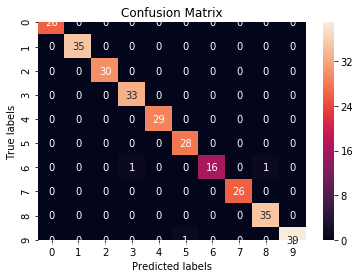

In [21]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
import seaborn as sns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
clf = RandomForestClassifier(n_estimators = 100)
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred, labels=[0,1,2,3,4,5,6,7,8,9])

# display(cm)

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_title('Confusion Matrix'); 
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 

## 2.3 Classify unknown data

In [22]:
PATH_TO_UNKNOWN_FILES = './datasets/eval/'
files = os.listdir(PATH_TO_UNKNOWN_FILES)

file_ids = []
eval_X = []

for file in files:
    # Load the signal using lobrosa
    signal, rate = librosa.load(PATH_TO_UNKNOWN_FILES + file, sr=None)
    
    # Compute the features array
    features = getFeaturesFromSamples(signal, rate)
    
    # Append the array as row to the features matrix
    eval_X.append(features)
    
    # Link the features to the current fiel id for solution
    file_ids.append(file.split('.')[0])

clf = RandomForestClassifier(n_estimators = 1000)
clf.fit(X, y)
eval_y = clf.predict(eval_X)

## 2.4 Save solution

In [23]:
with open("solution.csv", "w+") as f:
    f.seek(0)
    f.write("Id,Predicted\n")
    for file_id, label in zip(file_ids, eval_y):
        f.write(f"{file_id},{label}\n")